**1. 导入图像分类数据集**

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import torch_directml
import matplotlib as ma
import matplotlib.pyplot as plt
dml = torch_directml.device()
import time
from __init__ import init
init()
from IPython import display

**1.1 下载数据集**

> `transforms.ToTensor()` : 将 PIL 图像或 NumPy 数组转换为张量（Tensor）。

 * 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
 * 并除以255使得所有像素的数值均在0～1之间

In [2]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root='../data', train=True, transform=trans, download=False)
mnist_test = torchvision.datasets.FashionMNIST(
    root='../data', train=False, transform=trans, download=False)

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [5]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [6]:
# 可视化所有图片
def show_images(imgs, row, col, scales = 3, titles = None):
    fig, axes = plt.subplots(row, col, figsize=(col * scales, row * scales))
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            img = img.numpy()
        ax.imshow(img)
        ax.axis('off')
        if titles:
            ax.set_title(titles[i])
    plt.show()


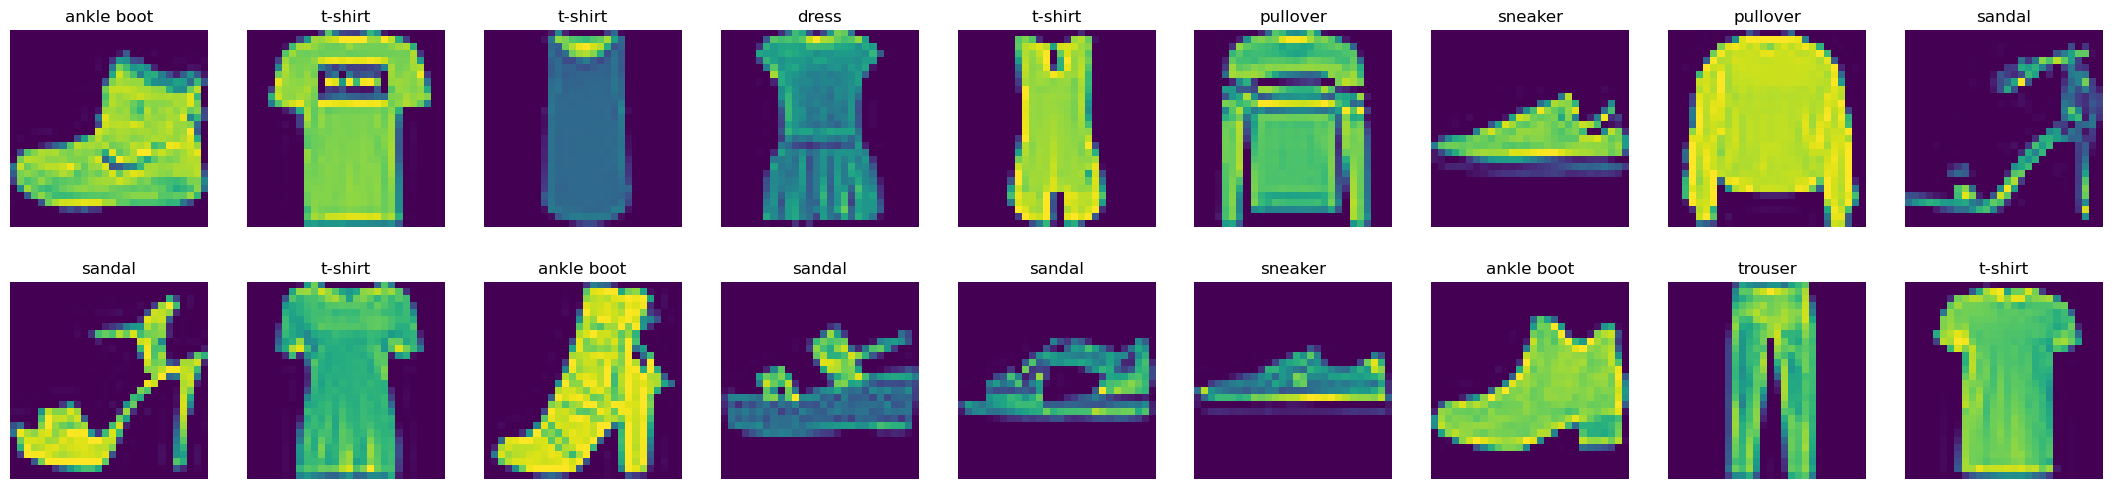

In [7]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, 3, get_fashion_mnist_labels(y));

**1.2 读取小批量**

使用 $8$ 个进程读数据

In [8]:
batch_size = 256

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4)

In [9]:
import time
start = time.time()
for X, y in train_iter:
    continue 
end = time.time()
print(f'time: {end - start}secs')

time: 5.246428489685059secs


**1.3 整合所有组件**

In [10]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root='../data', train=True, transform=trans, download=False)
    mnist_test = torchvision.datasets.FashionMNIST(
        root='../data', train=False, transform=trans, download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=4))

In [11]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


---

**2. softmax 回归**

In [12]:
from utils.util import *

In [13]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

**2.1 初始化模型参数**

In [14]:
num_inputs = 28 * 28
num_outputs = 10

w = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)# 默认生成的是一个行向量


**2.2 定义softmax函数, 模型, 精度**

In [15]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition
## 设置 keepdim=True 有利于广播操作正常进行

In [16]:
def net(X):
    return softmax(torch.matmul(X.view(-1, w.shape[0]), w) + b)

In [17]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
## 十分简洁的写法

In [18]:
def accuray(y_hat, y):
    y = y
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [19]:
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuray(net(X), y), y.numel())## 计入预测对的数量，与本次预测了多少个
    return metric[0] / metric[1]

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [20]:
evaluate_accuracy(net, test_iter)

0.1233

**2.3 训练**

In [21]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()# 为什么要取 mean
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0]) #输入为batch_size
        metric.add(float(l.sum()), accuray(y_hat, y), y.numel())
    # 返回模型的训练损失，精度
    return metric[0] / metric[2],  metric[1] / metric[2]

In [22]:
def set_axes(ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.legend(legend)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [23]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, 
                 ylim=None, xscale='linear', yscale='linear', 
                 fmts=('-', 'm--', 'g-', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=200)
        if nrows * ncols == 1:
            self.axes = [self.axes, ] #将单个变量变成列表，便于统一操作
        self.config_axes =  lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        # 默认支持最多绘制 4 条线
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        self.axes[0].grid()
        display.display(self.fig)
        display.clear_output(wait=True)

In [24]:
# tip : zip的功能
list(zip([1, 2, 3, 7, 8, 9 , 10],[1, 2, 3, 7, 8, 9 , 10], [1, 2, 3, 4, 6]))

[(1, 1, 1), (2, 2, 2), (3, 3, 3), (7, 7, 4), (8, 8, 6)]

In [25]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], 
                        legend=['train_loss', 'train_acc', 'test_acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc, ))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [26]:
from model.optim import sgd
lr = 0.1

def updater(batch_size):
    return sgd([w, b], lr, batch_size)

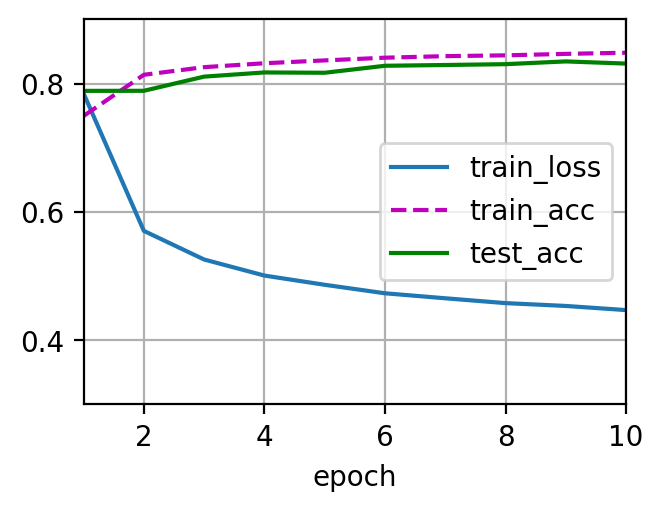

In [27]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

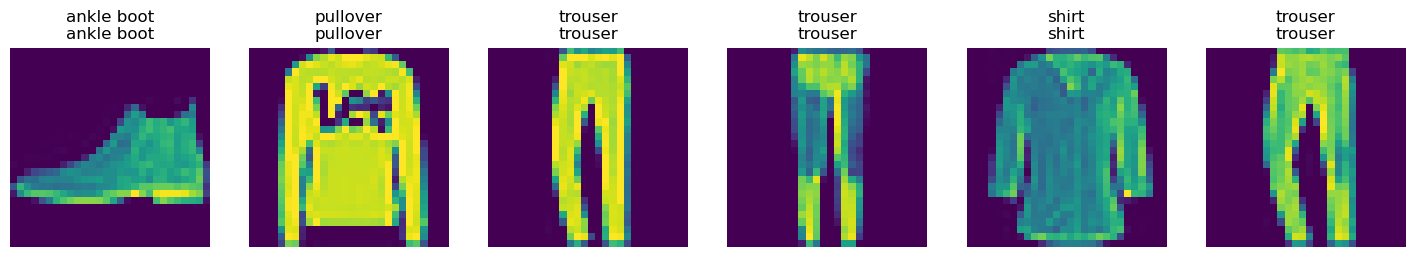

In [31]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred  for true, pred in zip(trues, preds)]
    show_images(X[0:n].view(-1, 28, 28), 1, n, titles=titles[0:n])
predict_ch3(net, test_iter)